Amel AIMEUR  
Imane ZARAR
# Projet : Prédiction du climat dans la ville de Delhi

# Importation des librairies

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_squared_error


## Représentation des données

In [68]:
df_train = pd.read_csv("DailyDelhiClimateTrain.csv")
df_test = pd.read_csv("DailyDelhiClimateTest.csv")

print("Nombre de lignes : ",df_train.shape[0], "\t Nombre de colonnes :",df_train.shape[1])
df_train.head()

Nombre de lignes :  1462 	 Nombre de colonnes : 5


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [69]:
# Convertir la colonne 'date' en objet datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# Comme index du DataFrame on prend la colonne date 
df_train.set_index('date', inplace=True)
# Rééchantillonne les données à une fréquence mensuelle et calculer la moyenne
df_train_mois = df_train['meantemp'].resample('M').mean()
# Rééchantillonne les données à une fréquence hebdomadaire et calculer la moyenne
df_train_semaine = df_train['meantemp'].resample('W').mean()

# Convertir la colonne 'date' en objet datetime
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date', inplace=True)
# Rééchantillonne les données de test à une fréquence mensuelle et calculer la moyenne
df_test_mois = df_test['meantemp'].resample('M').mean()
# Rééchantillonn les données de test à une fréquence hebdomadaire et calculer la moyenne
df_test_semaine = df_test['meantemp'].resample('W').mean()


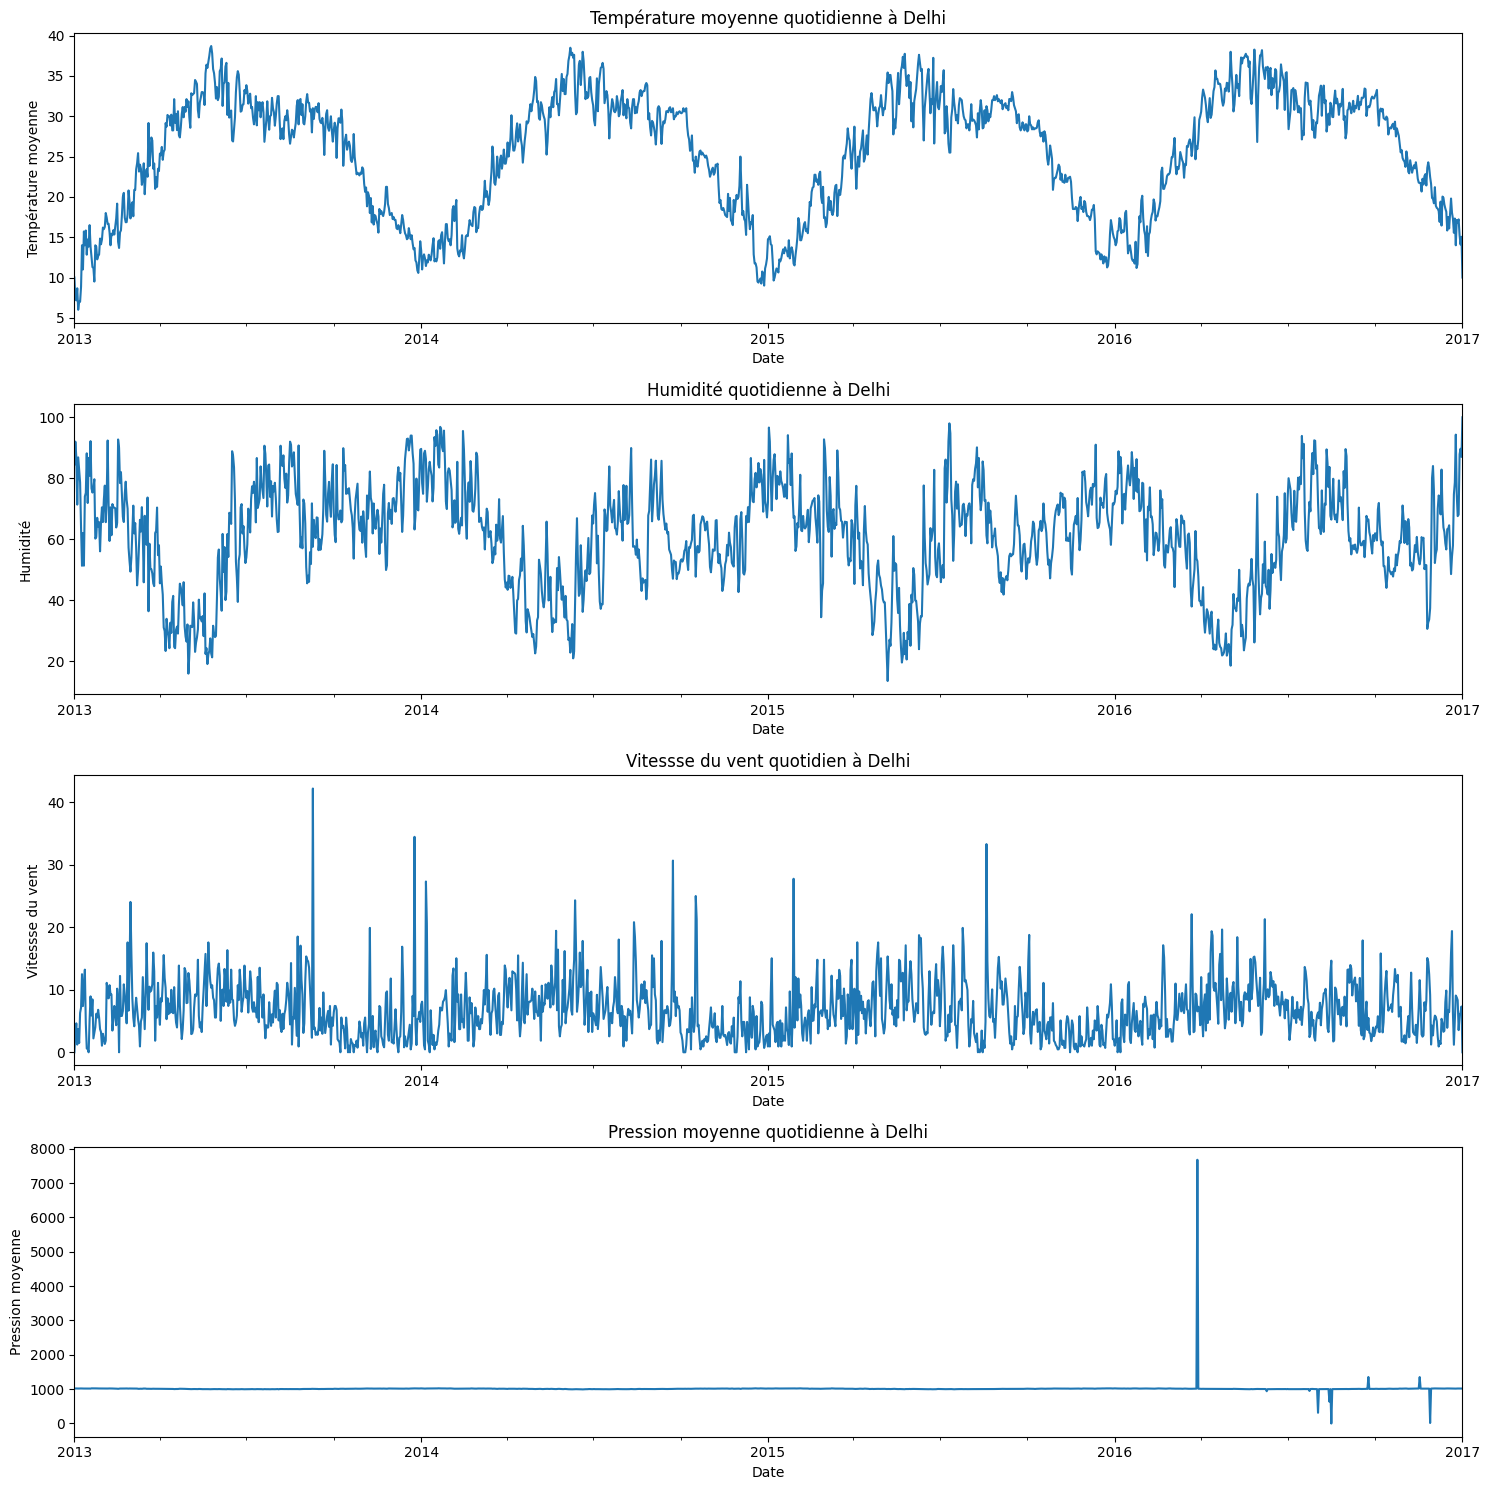

In [70]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, figsize=(15, 15))

df_train["meantemp"].plot(ax=ax1, xlabel="Date", ylabel="Température moyenne", title="Température moyenne quotidienne à Delhi")
df_train["humidity"].plot(ax=ax2, xlabel="Date", ylabel="Humidité", title="Humidité quotidienne à Delhi")
df_train["wind_speed"].plot(ax=ax3, xlabel="Date", ylabel="Vitessse du vent", title="Vitessse du vent quotidien à Delhi")
df_train["meanpressure"].plot(ax=ax4, xlabel="Date", ylabel="Pression moyenne", title="Pression moyenne quotidienne à Delhi")
plt.tight_layout()


En examinant les graphiques ci-dessus, nous pouvons clairement identifier des schémas de saisonnalité dans les séries temporelles de la température moyenne et de l'humidité quotidienne à Delhi.

Dans le premier graphique, représentant la température moyenne quotidienne, nous observons des variations cycliques récurrentes au fil du temps. Ces motifs suggèrent une saisonnalité, où la température semble suivre un schéma prévisible qui se répète à intervalles réguliers.

De manière similaire, le deuxième graphique illustrant  présente également des variations périodiques, indiquant la présence d'une saisonnalité dans cette série temporelle.

In [71]:
df_train.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [72]:
df_test.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

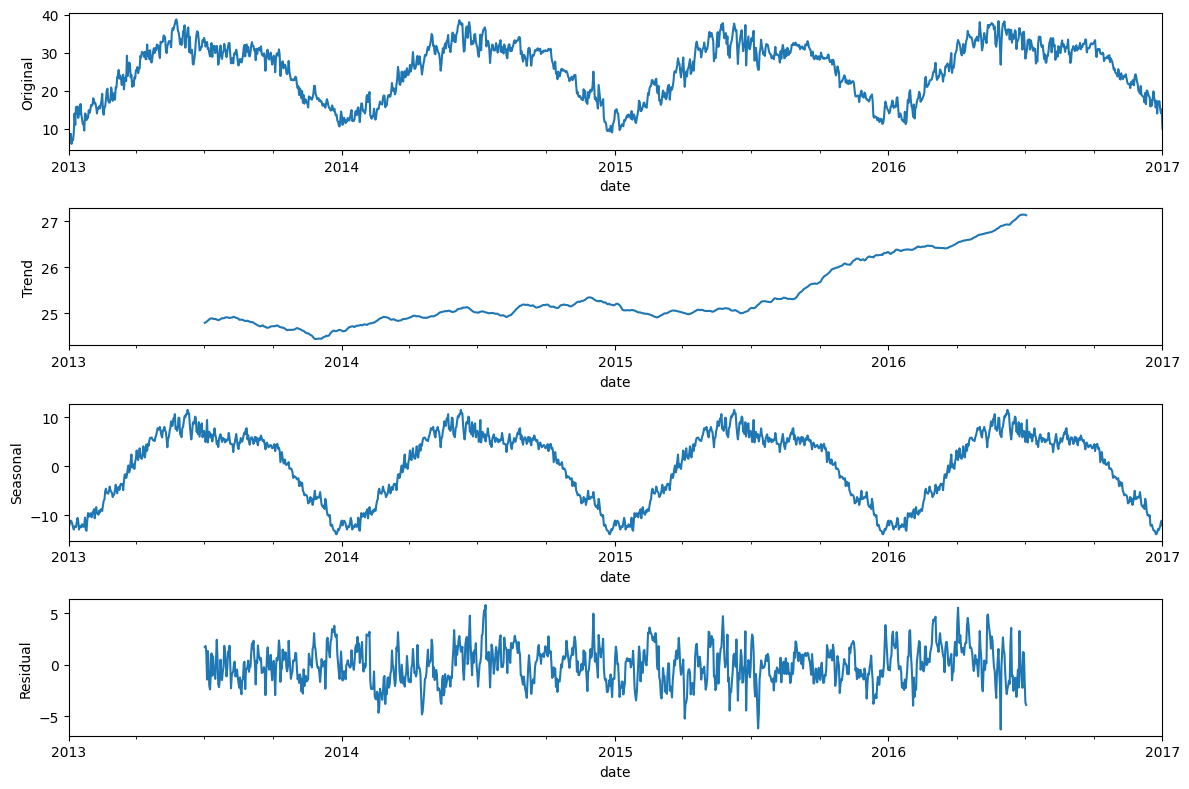

In [73]:
column_to_analyze = 'meantemp'
result = seasonal_decompose(df_train[column_to_analyze], model='additive', period=365)

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 8))

result.observed.plot(ax=ax1)
ax1.set(ylabel='Original')

result.trend.plot(ax=ax2)
ax2.set(ylabel='Trend')

result.seasonal.plot(ax=ax3)
ax3.set(ylabel='Seasonal')

result.resid.plot(ax=ax4)
ax4.set(ylabel='Residual')

plt.tight_layout()
plt.show()

## Verification de la stationnarité de la série

A l'aide du test de Dickey-Fuller, on évalue si la série est staionnaire ou non. 

In [74]:
# Effectue le test Dickey-Fuller
adf_test = adfuller(df_train['meantemp'])
adf_statistic=adf_test[0]# statistique du test
adf_critical_value = adf_test[4]['5%'] # valeur critique 
# Comparer la statistique du test à la valeur critique
if adf_statistic < adf_critical_value:
    print("La série temporelle est stationnaire (rejette l'hypothèse nulle)")
else:
    print("La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)")

adf_test

La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)


(-2.0210690559206705,
 0.2774121372301612,
 10,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.895746470953)

Ici, le test Dickey-Fuller a été utilisé pour évaluer la stationnarité de la série temporelle de la température moyenne.La stationnarité, a été évaluée en comparant la statistique du test à la valeur critique au niveau de signification de 5%.

Le résultat du test indique que la statistique du test (−2.021) est supérieure à la valeur critique (−2.863) au seuil de 5%. En conséquence, la série temporelle n'est pas stationnaire, suggérant la présence d'une tendance ou d'une non-stationnarité.

La p-value associée au test est 0.28, ce qui confirme également que la série temporelle n'est pas stationnaire, car la p-value est supérieure au seuil de 0.05. 
Ainsi, afin de rendre la série temporelle stationnaire, on effectue une différenciation. 

In [75]:
df_diff = df_train['meantemp'].diff().dropna()  # Différenciation d'ordre 1

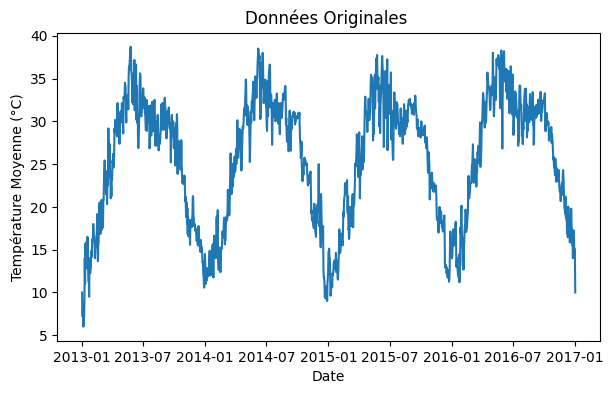

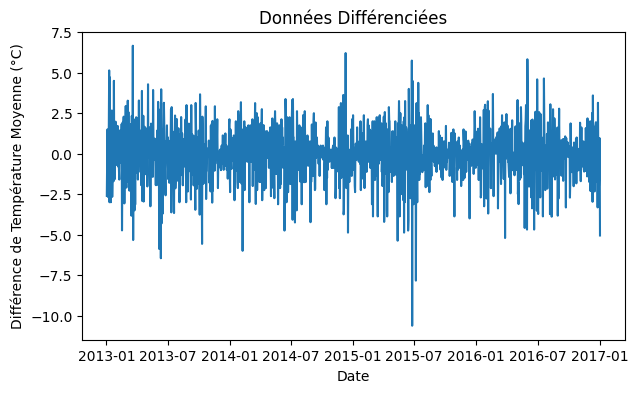

In [76]:
# Tracé pour les données originales
plt.figure(figsize=(7, 4))
plt.plot(df_train['meantemp'])
plt.title('Données Originales ')
plt.xlabel('Date')
plt.ylabel('Température Moyenne (°C)')
plt.show()

# Tracé pour les données différenciées
plt.figure(figsize=(7, 4))
plt.plot(df_diff)
plt.title('Données Différenciées')
plt.xlabel('Date')
plt.ylabel('Différence de Température Moyenne (°C)')
plt.show()



In [77]:
# Effectuer le test Dickey-Fuller sur la série différenciée
adf_test = adfuller(df_diff)
adf_statistic=adf_test[0]# statistique du test
adf_critical_value = adf_test[4]['5%'] # valeur critique 
# Comparer la statistique du test à la valeur critique
if adf_statistic < adf_critical_value:
    print("La série temporelle est stationnaire (rejette l'hypothèse nulle)")
else:
    print("La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)")

adf_test

La série temporelle est stationnaire (rejette l'hypothèse nulle)


(-16.378720267074694,
 2.7648631375945265e-29,
 9,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.097584257939)

Suite à l'application d'une différenciation première, la série temporelle a été rendue stationnaire, comme en témoigne la statistique du test Dickey-Fuller (− 16.378) largement inférieure à la valeur critique au seuil de 1%. La p-value extrêmement faible ( ${2.765 × 10^{−29}}$  ) renforce la conclusion que la série temporelle différenciée est stationnaire. 

## ACF et PACF

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


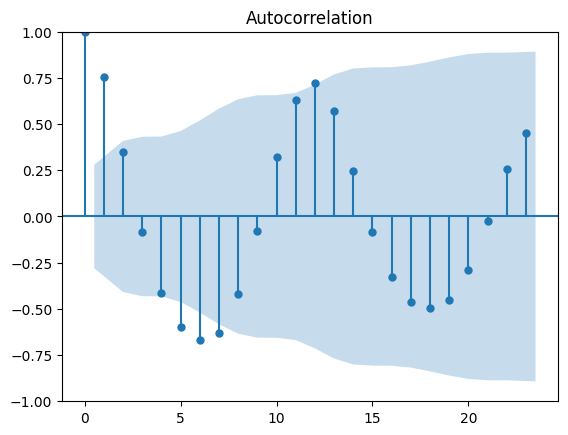

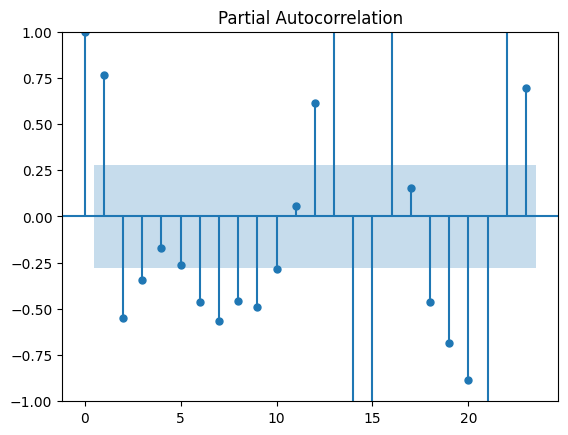

In [78]:
acf_plot = plot_acf(df_train_mois, lags=23)
pacf_plot = plot_pacf(df_train_mois, lags=23)

plt.show()

 L'ACF (Autocorrelation Function) mesure la corrélation entre les observations actuelles et les observations passées à différents retards temporels. L'analyse de l'ACF de notre série temporelle révèle des motifs significatifs de corrélation périodique, suggérant la présence de saisonnalité dans les données.

La présence de pics significatifs dans l'ACF, se répétant à une fréquence régulière de 12 mois, indique clairement une composante saisonnière dans la série temporelle. Ces pics périodiques suggèrent que les observations sont influencées par des variations saisonnières qui se répètent à intervalles réguliers de 12 mois.

C'est précisément dans de telles situations que le modèle SARIMA (Seasonal AutoRegressive Integrated Moving Average) excelle. En intégrant la composante saisonnière, le modèle SARIMA permet une modélisation précise et une prévision efficace des données temporelles présentant des cycles annuels marqués.

Dans le cas présent, la période saisonnière est de 12 mois (S=12), ce qui signifie que les variations saisonnières se répètent chaque année. L'inclusion de cette information saisonnière dans le modèle SARIMA devrait améliorer significativement sa capacité à faire des prévisions précises en prenant en compte les schémas récurrents associés à la saisonnalité. 


### Modélisation SARIMA pour les Données mensuelles 

In [79]:
df_diff_mois = df_train_mois.diff().dropna()  # Différenciation d'ordre 1

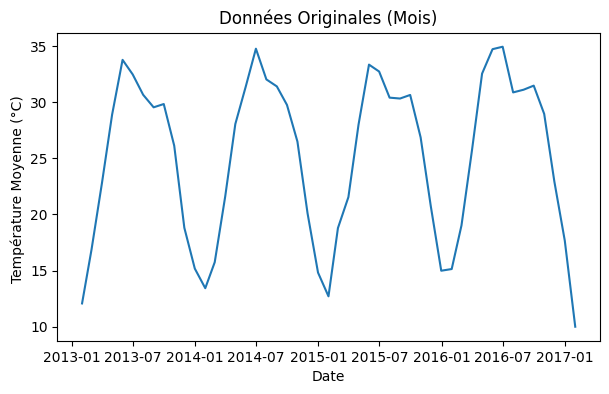

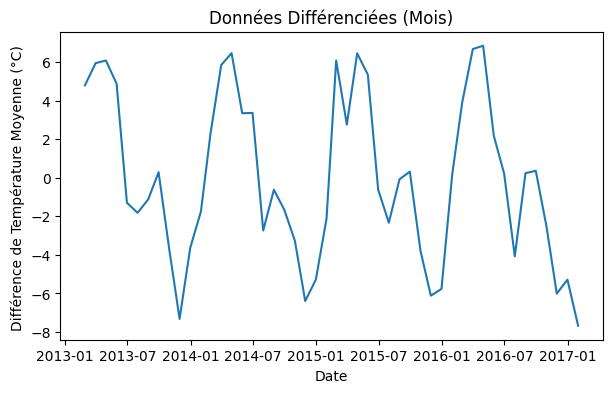

In [80]:
# Tracé pour les données originales
plt.figure(figsize=(7, 4))
plt.plot(df_train_mois)
plt.title('Données Originales (Mois)')
plt.xlabel('Date')
plt.ylabel('Température Moyenne (°C) ')
plt.show()

# Tracé pour les données différenciées
plt.figure(figsize=(7, 4))
plt.plot(df_diff_mois)
plt.title('Données Différenciées (Mois)')
plt.xlabel('Date')
plt.ylabel('Différence de Température Moyenne (°C) ')
plt.show()



In [81]:
# Effectuer le test Dickey-Fuller sur la série différenciée
adf_test = adfuller(df_diff_mois)
adf_statistic=adf_test[0]# statistique du test
adf_critical_value = adf_test[4]['5%'] # valeur critique 
# Comparer la statistique du test à la valeur critique
if adf_statistic < adf_critical_value:
    print("La série temporelle est stationnaire (rejette l'hypothèse nulle)")
else:
    print("La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)")

adf_test

La série temporelle est stationnaire (rejette l'hypothèse nulle)


(-7.2758684401062546,
 1.5450729805971367e-10,
 9,
 38,
 {'1%': -3.6155091011809297,
  '5%': -2.941262357486514,
  '10%': -2.6091995013850418},
 152.99503872520177)

### Identification Automatique des Ordres Optimaux avec pm.auto_arima

Pour modéliser de manière optimale la série temporelle, nous avons choisi d'utiliser la fonction `pm.auto_arima`. Cette fonction offre une approche automatisée et robuste pour la sélection des ordres optimaux d'un modèle SARIMA en fonction de critères tels que l'AIC (Akaike Information Criterion) ou le BIC (Bayesian Information Criterion).

En utilisant `pm.auto_arima`, le processus de sélection des ordres du modèle est simplifié, éliminant ainsi la nécessité de spécifier manuellement les ordres SARIMA. La fonction effectue une recherche exhaustive sur plusieurs combinaisons possibles d'ordres, permettant ainsi de trouver rapidement les paramètres optimaux qui captureront efficacement la saisonnalité présente dans la série temporelle.

La spécification `seasonal=True` indique explicitement à la fonction de prendre en compte la composante saisonnière dans le modèle, avec une période saisonnière de 12 mois (`m=12`). Ces paramètres sont cruciaux pour garantir que le modèle SARIMA ajusté reflète correctement les variations saisonnières qui se produisent à intervalles réguliers de 12 mois.


In [177]:
best_model =pm.auto_arima(df_train_mois,
                      seasonal=True, m=12,
                      trace=True,
                      error_action='ignore') 

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=154.686, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=147.633, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=156.606, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=155.971, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=147.522, Time=0.32 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=149.432, Time=0.55 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=147.497, Time=0.18 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=149.432, Time=0.53 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=147.449, Time=0.36 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=148.932, Time=0.19 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=149.00

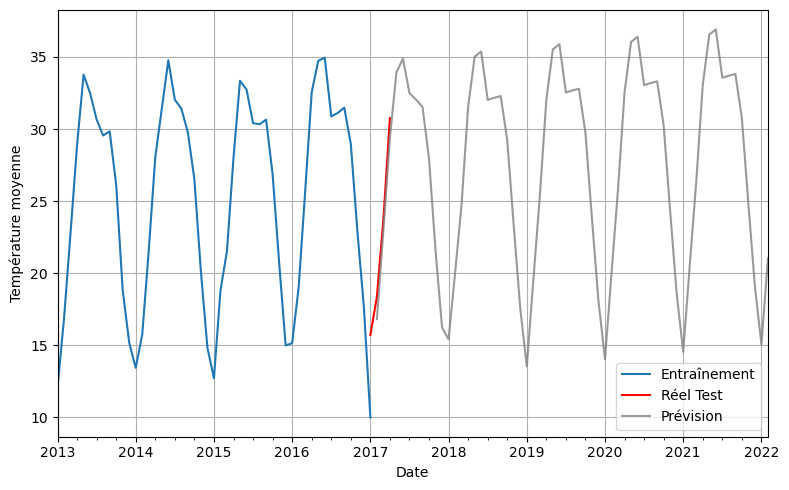

In [178]:
# Prévisions pour la durée de l'ensemble de données de test
forecast_values, conf_int = best_model.predict(n_periods=len(df_train_mois)+12, return_conf_int=True)

forecast_index = forecast_values.index

forecast_series = pd.Series(forecast_values, index=forecast_index)
# Tracer les valurs réelles par rapport aux previsions
plt.figure(figsize=(8, 5))
df_train_mois.plot(label='Entraînement', legend=True)
df_test_mois.plot(label='Réel Test', legend=True, color='red')
forecast_series.plot(label='Prévision', legend=True, color='grey', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Température moyenne')
plt.grid(True)
plt.tight_layout()
plt.show()


In [179]:
actual_values= df_test_mois.reindex(forecast_series.index)
# Supprimer les valeurs manquantes desvaleurs réelles
actual_values =actual_values.dropna()
#Extraire les valeurs prévues du modèle SARIMA
forecast_values =forecast_series[actual_values.index]
#Calculer l'errur quadratique moyenne
mse = mean_squared_error(actual_values, forecast_values)
#Calculer la racine carrée de l'erreur quadratique moyenne
rmse =np.sqrt(mse)
print("RMSE pour les prévisions SARIMA mensuelles :",rmse)


RMSE pour les prévisions SARIMA mensuelles : 1.2618491387393174


### Modélisation SARIMA pour les Données hebdomadaires 

Pour les données hebdomadaires, nous appliquons à nouveau un modèle SARIMA pour tenir compte de la saisonnalité. Cette fois, la période saisonnière est de 52 semaines (S=52), reflétant la nature hebdomadaire des variations saisonnières dans la série temporelle.

In [180]:
best_model = pm.auto_arima(df_train_semaine,
                      seasonal=True, m=52,
                      trace=True,
                      suppress_warnings=True) 

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=7.41 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1422.446, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=894.427, Time=1.41 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1964.675, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=900.013, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=893.796, Time=7.58 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=32.12 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.08 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=21.98 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=891.595, Time=10.63 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=893.537, Time=2.25 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=31.98 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=8.35 sec
 ARIMA(3,0,0)(2,0,0)[52] intercept   : AIC=893.547, Tim

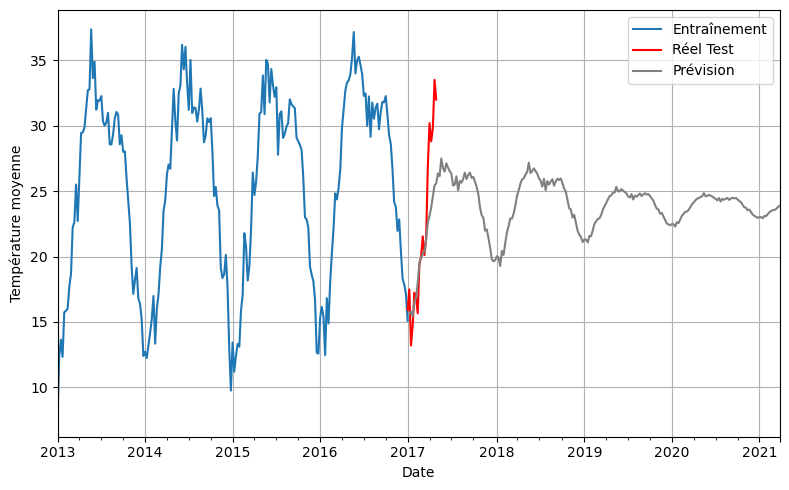

In [115]:
# Prévisions pour la durée de l'ensemble de données de test
forecast_values, conf_int = best_model.predict(n_periods=len(df_train_semaine)+12, return_conf_int=True)

# Créer un index de date pour forecast_values
forecast_index = forecast_values.index

forecast_series = pd.Series(forecast_values, index=forecast_index)

# Tracer les valeurs réelles par rapport aux prévionbs
plt.figure(figsize=(8, 5))
df_train_semaine.plot(label='Entraînement', legend=True)
df_test_semaine.plot(label='Réel Test', legend=True, color='red')
forecast_series.plot(label='Prévision', legend=True, color='grey')
plt.xlabel('Date')
plt.ylabel('Température moyenne')
plt.grid(True)
plt.tight_layout()
plt.show()


In [116]:
# Réindexer les séries temporelles
actual_values= df_test_semaine.reindex(forecast_series.index)
# Supprimer les valeurs manquantes des valeurs réelles
actual_values =actual_values.dropna()
# Extraire les valeurs prévues du modèle SARIMA
forecast_values =forecast_series[actual_values.index]
# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(actual_values, forecast_values)
# Calculer la racine carrée de l'erreur quadratique moyenne
rmse =np.sqrt(mse)
print("RMSE pour les prévisions SARIMA hebdomadaires :",rmse)


RMSE pour les prévisions SARIMA hebdomadaires : 3.806039942929571


## Approches naïves

Dans cette section, nous explorons trois stratégies naïves pour prédire les données de température moyenne quotidienne à Delhi.

1. **Last Value (last) :** Cette stratégie consiste à utiliser la dernière valeur observée comme prédiction pour le futur. Elle repose sur l'idée que la tendance actuelle persiste.

2. **Last Value with Seasonal Adjustment (last avec sp) :** En introduisant une composante saisonnière, cette approche ajuste la prédiction en prenant en compte la saisonnalité des données. Dans notre cas , nous avons utilisé une saisonnalité de 365 jours (sp=365) pour tenir compte des variations saisonnières annuelles.

3. **Drift :** La méthode du "drift" suppose que la série temporelle suit une tendance constante sur une période spécifiée. Nous évaluons ici lla performance de cette approche en supposant un déplacement linéaire dans les données.



#### Last Value (last) :

RMSE pour la méthode Naive avec strategy 'last' : 13.315100549507218


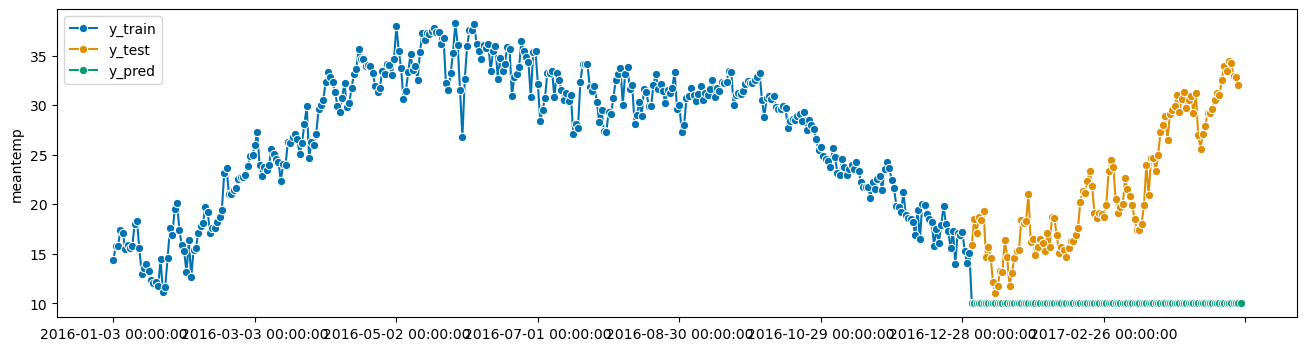

In [117]:
# La prédiction se fait sur l'horizon suivant
fh = np.arange(1, len(df_test) + 1) 
# Pour limiter le nombre de points, on ne prend que les 365 derniers (1 année)
y_train = df_train[-365:]

# Sélectionner uniquement la variable 'meantemp'
y_train = y_train['meantemp']

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# Visualise uniquement la variable 'meantemp'
plot_series(y_train, df_test['meantemp'], y_pred, labels=["y_train", "y_test", "y_pred"]);

smape_loss(y_pred, df_test['meantemp'])
rmse = np.sqrt(mean_squared_error(df_test["meantemp"], y_pred))
print("RMSE pour la méthode Naive avec strategy 'last' :",rmse)


#### Last Value with Seasonal Adjustment (last avec sp) :

RMSE pour la méthode Naive avec strategy 'last' et sp=365 : 3.0923941864018882


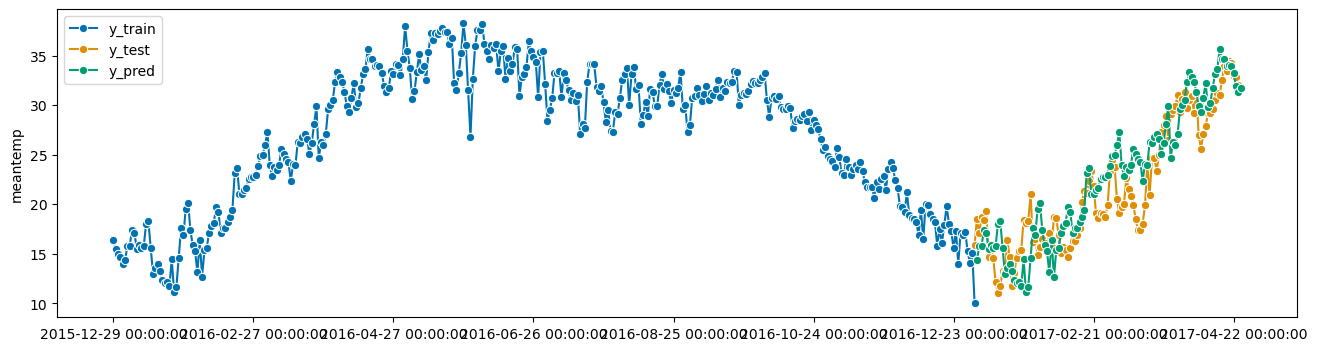

In [118]:
# La prédiction se fait sur l'horizon suivant
# Spécifie la fréquence pour les données d'entraînement et de test
df_train.index.freq = 'D'
df_test.index.freq = 'D'

fh = np.arange(1, len(df_test) + 1) 
# Pour limiter le nombre de points, on ne prend que les 370 derniers
y_train = df_train["meantemp"][-370:]

forecaster = NaiveForecaster(strategy='last', sp=365)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, df_test["meantemp"], y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, df_test["meantemp"])

rmse = np.sqrt(mean_squared_error(df_test["meantemp"], y_pred))
print("RMSE pour la méthode Naive avec strategy 'last' et sp=365 :",rmse)


#### Drift :

RMSE pour la méthode Naive avec strategy 'drift' : 14.092797301562717


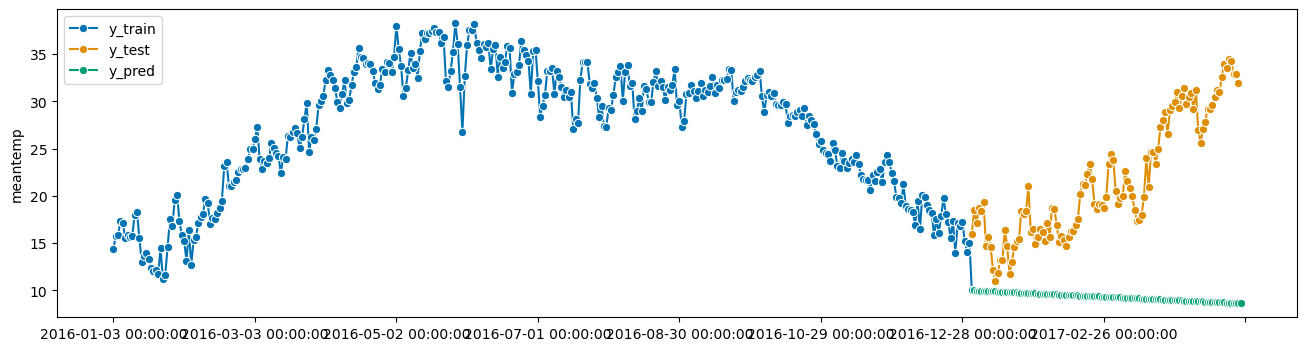

In [119]:
# La prédiction se fait sur l'horizon suivant
fh = np.arange(1, len(df_test) + 1) 
# Pour limiter le nombre de points, on ne prend que les 200 derniers
y_train = df_train["meantemp"][-365:]

forecaster = NaiveForecaster(strategy="drift")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# Visualiser uniquement la variable 'meantemp'
plot_series(y_train, df_test['meantemp'], y_pred, labels=["y_train", "y_test", "y_pred"]);

smape_loss(y_pred, df_test['meantemp'])
rmse = np.sqrt(mean_squared_error(df_test["meantemp"], y_pred))
print("RMSE pour la méthode Naive avec strategy 'drift' :",rmse)


Parmi les différentes approches naïves testées, la stratégie 'last' avec une composante saisonnière annuelle (sp=365) se démarque comme la plus performante. Cette configuration réduit significativement le RMSE à 3.09, suggérant que l'introduction d'une saisonnalité quotidienne basée sur l'année précédente améliore considérablement la précision des prévisions.

## Modelisation LSTM  pour les donnees quotidiennes

In [82]:
dataset = df_train["meantemp"]
dataset = pd.DataFrame(dataset)
data = dataset.values


### Normalisation des températures avec MinMaxScaler

In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))


In [84]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [85]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1096, 1)

In [86]:
#Initialisation des listes x_train et y_train :

x_train = []
y_train = []
time_steps = 60 #on utilise les 60 dernières observations pour faire la prédiction.
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)
        

X_train:  [array([[0.12227074],
       [0.04279476],
       [0.0356623 ],
       [0.08151383],
       [0.        ],
       [0.03056769],
       [0.03056769],
       [0.08733624],
       [0.24454148],
       [0.15283843],
       [0.29694323],
       [0.24454148],
       [0.30058224],
       [0.20887918],
       [0.26637555],
       [0.23944687],
       [0.3209607 ],
       [0.23944687],
       [0.19868996],
       [0.16157205],
       [0.15895197],
       [0.1069869 ],
       [0.24454148],
       [0.23944687],
       [0.19104803],
       [0.20378457],
       [0.20960699],
       [0.27001456],
       [0.24836245],
       [0.26637555],
       [0.31179039],
       [0.30567686],
       [0.31441048],
       [0.36681223],
       [0.34934498],
       [0.32478166],
       [0.32605531],
       [0.29344978],
       [0.24454148],
       [0.28820961],
       [0.28275109],
       [0.3018559 ],
       [0.2852984 ],
       [0.31441048],
       [0.34643377],
       [0.40247453],
       [0.25764192],
  

Cette partie du code convertit les listes x_train et y_train en tableaux numpy et redimensionne x_train pour le préparer à être l'entrée de notre modèle de deep learning LSTM qui traite des séquences.

In [87]:
x_train, y_train = np.array(x_train), np.array(y_train)
#Redimensionnement de l'entrée en (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [88]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
history = model.fit(x_train, y_train, epochs= 50, batch_size= 32)

Epoch 1/50
44/44 [==============================] - 7s 58ms/step - loss: 0.0254 - mean_absolute_error: 0.1126
Epoch 2/50
44/44 [==============================] - 3s 63ms/step - loss: 0.0054 - mean_absolute_error: 0.0581
Epoch 3/50
44/44 [==============================] - 3s 62ms/step - loss: 0.0049 - mean_absolute_error: 0.0552
Epoch 4/50
44/44 [==============================] - 3s 62ms/step - loss: 0.0048 - mean_absolute_error: 0.0546
Epoch 5/50
44/44 [==============================] - 3s 61ms/step - loss: 0.0048 - mean_absolute_error: 0.0544
Epoch 6/50
44/44 [==============================] - 3s 61ms/step - loss: 0.0047 - mean_absolute_error: 0.0538
Epoch 7/50
44/44 [==============================] - 3s 61ms/step - loss: 0.0044 - mean_absolute_error: 0.0517
Epoch 8/50
44/44 [==============================] - 3s 61ms/step - loss: 0.0043 - mean_absolute_error: 0.0512
Epoch 9/50
44/44 [==============================] - 3s 62ms/step - loss: 0.0042 - mean_absolute_error: 0.0505
Epoch 10/5

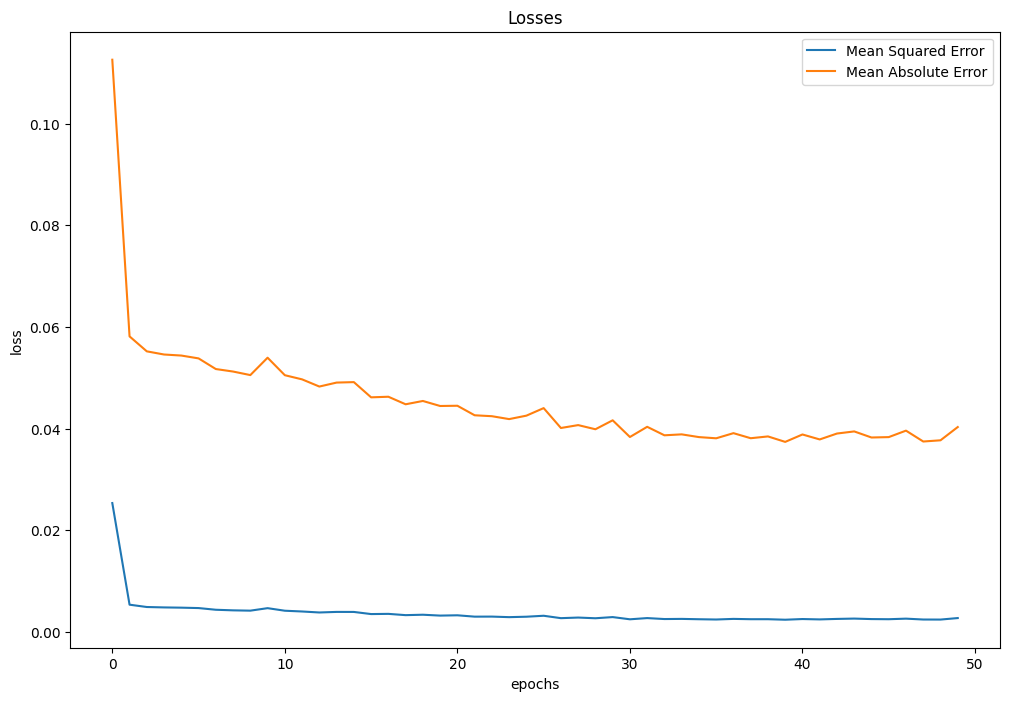

In [92]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [93]:
#Création d'un ensemble de test avec 60 pas de temps et 1 sortietime_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [94]:
predictions = model.predict(x_test)


12/12 [==============================] - 1s 21ms/step


#### Inversion de la mise à l'échelle des prédictions pour interprétation des résultats

In [95]:
#Inverser la mise à l'échelle des predictions

predictions = scaler.inverse_transform(predictions)
predictions.shape

(366, 1)

In [96]:
#Inverser la mise à l'échelle de y_test

y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE


0.51

In [97]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,13.997654,14.000000
1,13.547628,14.375000
2,13.591574,15.750000
3,14.394141,15.833333
4,14.800985,17.375000
...,...,...
361,16.187521,17.217391
362,16.446087,15.238095
363,15.391120,14.095238
364,14.361415,15.052632


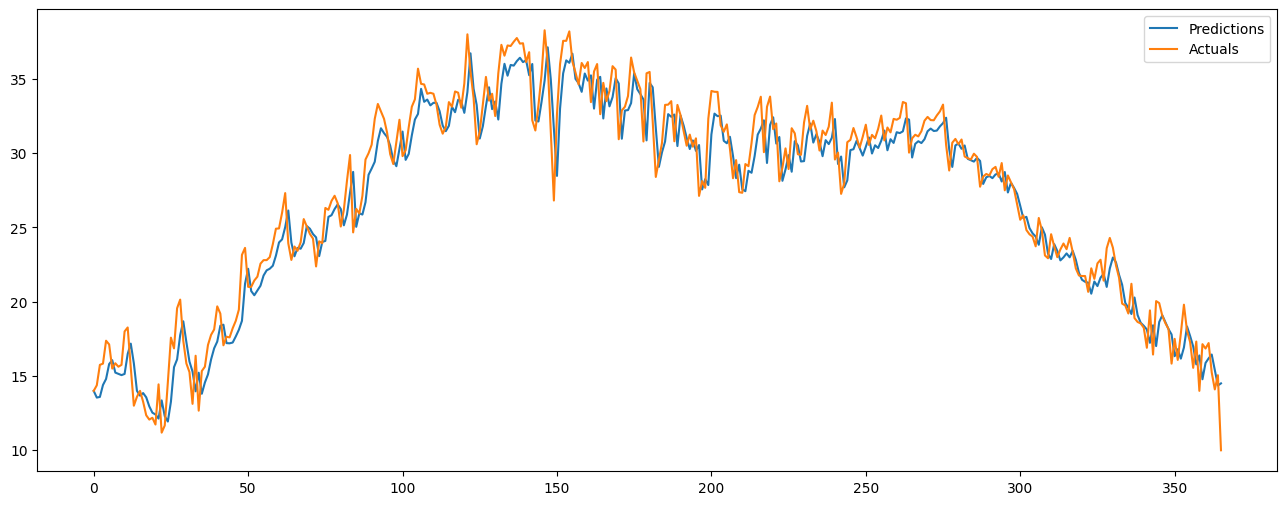

In [98]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

Le modèle semble également capturer de manière assez précise certains des pics et creux des données réelles. Cependant, il y a des zones où les prédictions ne correspondent pas parfaitement aux valeurs réelles, ce qui est normal et attendu dans la prédiction de séries temporelles,cependant il semble faire un bon travail en suivant les tendances générales des données réelles. Les deux lignes montent et descendent généralement ensemble, ce qui indique que le modèle a pu apprendre une partie significative de la dynamique sous-jacente des données.

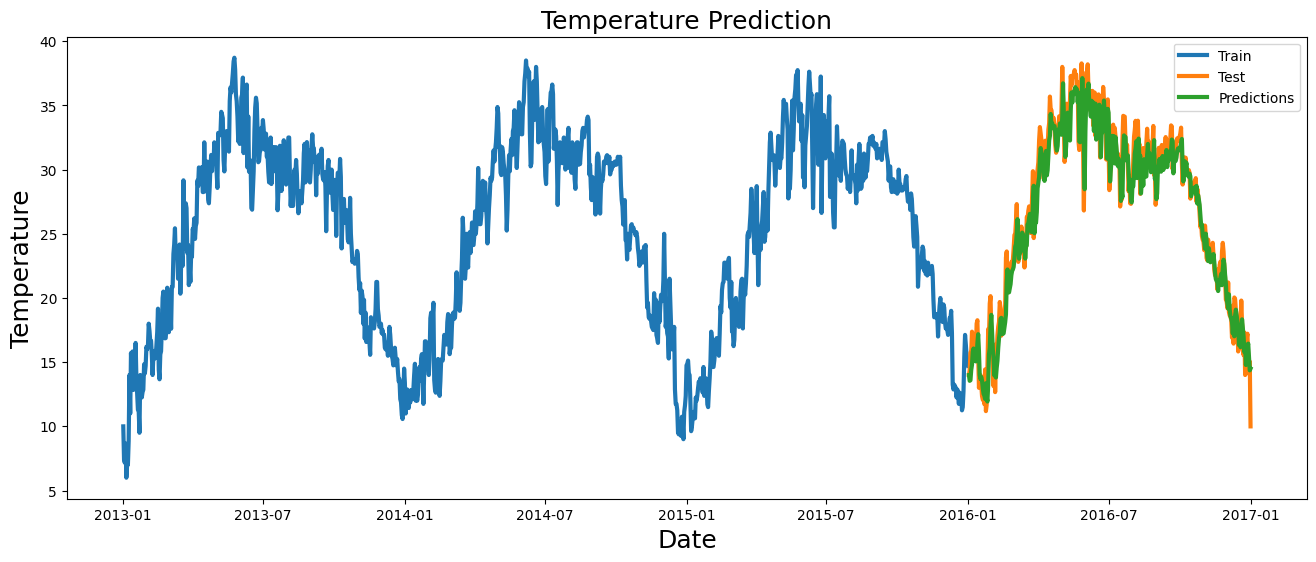

In [99]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

Le graphique montre les prédictions de température d'un modèle LSTM en comparaison avec les données réelles d'entraînement et de test. Les prédictions vertes épousent étroitement les valeurs réelles orange, démontrant l'efficacité du modèle à suivre les tendances saisonnières. Des écarts mineurs entre les prédictions et les données de test suggèrent des opportunités pour peaufiner davantage le modèle.

### Appliquons LSTM  pour les donnees hebdomadaires

In [115]:
dataset = df_train_semaine
dataset = pd.DataFrame(dataset)
data_week = dataset.values

In [116]:
from sklearn.preprocessing import MinMaxScaler
scaler_weekly = MinMaxScaler(feature_range= (0, 1))
scaled_data_weekly = scaler_weekly.fit_transform(np.array(data_week).reshape(-1, 1))


In [117]:
# Créer des séquences pour les données hebdomadaires
x_train_weekly, y_train_weekly = [], []
time_steps = 60  
for i in range(time_steps, len(scaled_data_weekly)):
    x_train_weekly.append(scaled_data_weekly[i-time_steps:i, 0])
    y_train_weekly.append(scaled_data_weekly[i, 0])
    
x_train_weekly, y_train_weekly = np.array(x_train_weekly), np.array(y_train_weekly)
x_train_weekly = np.reshape(x_train_weekly, (x_train_weekly.shape[0], x_train_weekly.shape[1], 1))


In [118]:
train_size = int(len(data_week) * 0.75)
test_size = len(data_week) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 156 Test Size : 53


In [119]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train_weekly.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_9 (LSTM)               (None, 64)                29440     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
history = model.fit(x_train_weekly, y_train_weekly, epochs= 50, batch_size= 32)

Epoch 1/50
5/5 [==============================] - 6s 59ms/step - loss: 0.1775 - mean_absolute_error: 0.3477
Epoch 2/50
5/5 [==============================] - 0s 56ms/step - loss: 0.0723 - mean_absolute_error: 0.2206
Epoch 3/50
5/5 [==============================] - 0s 62ms/step - loss: 0.0540 - mean_absolute_error: 0.2014
Epoch 4/50
5/5 [==============================] - 0s 60ms/step - loss: 0.0391 - mean_absolute_error: 0.1682
Epoch 5/50
5/5 [==============================] - 0s 69ms/step - loss: 0.0353 - mean_absolute_error: 0.1537
Epoch 6/50
5/5 [==============================] - 0s 63ms/step - loss: 0.0298 - mean_absolute_error: 0.1372
Epoch 7/50
5/5 [==============================] - 0s 60ms/step - loss: 0.0283 - mean_absolute_error: 0.1433
Epoch 8/50
5/5 [==============================] - 0s 64ms/step - loss: 0.0242 - mean_absolute_error: 0.1314
Epoch 9/50
5/5 [==============================] - 0s 56ms/step - loss: 0.0218 - mean_absolute_error: 0.1179
Epoch 10/50
5/5 [===========

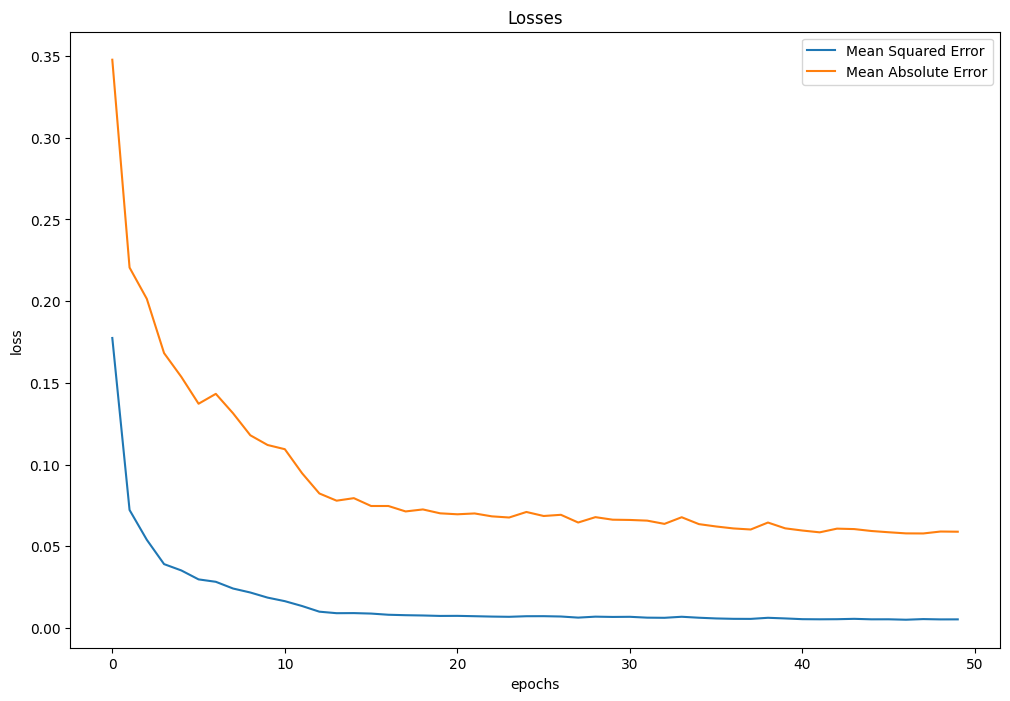

In [121]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

La courbe montre une diminution constante des erreurs quadratique moyenne et absolue moyenne au fil des époques, indiquant que le modèle d'apprentissage automatique s'améliore avec l'entraînement. La convergence des deux métriques de perte suggère que le modèle se stabilise vers une performance optimale. La courbe lisse sans fluctuations majeures implique un apprentissage stable et progressif du modèle.

In [122]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data_weekly[train_size - time_steps:, :]

x_test_weekly = []
y_test_weekly = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test_weekly.append(test_data[i-time_steps:i, 0:n_cols])
    y_test_weekly.append(test_data[i, 0:n_cols])
x_test_weekly, y_test_weekly = np.array(x_test_weekly), np.array(y_test_weekly)
x_test_weekly = np.reshape(x_test_weekly, (x_test_weekly.shape[0], x_test_weekly.shape[1], n_cols))

In [123]:
predictions = model.predict(x_test_weekly)


2/2 [==============================] - 1s 16ms/step


In [124]:
#inverse predictions scaling
predictions = scaler_weekly.inverse_transform(predictions)
predictions.shape

(53, 1)

In [125]:
#inverse y_test scaling
y_test_weekly = scaler_weekly.inverse_transform(y_test_weekly)
RMSE = np.sqrt(np.mean( y_test_weekly - predictions )**2).round(2)
RMSE

0.17

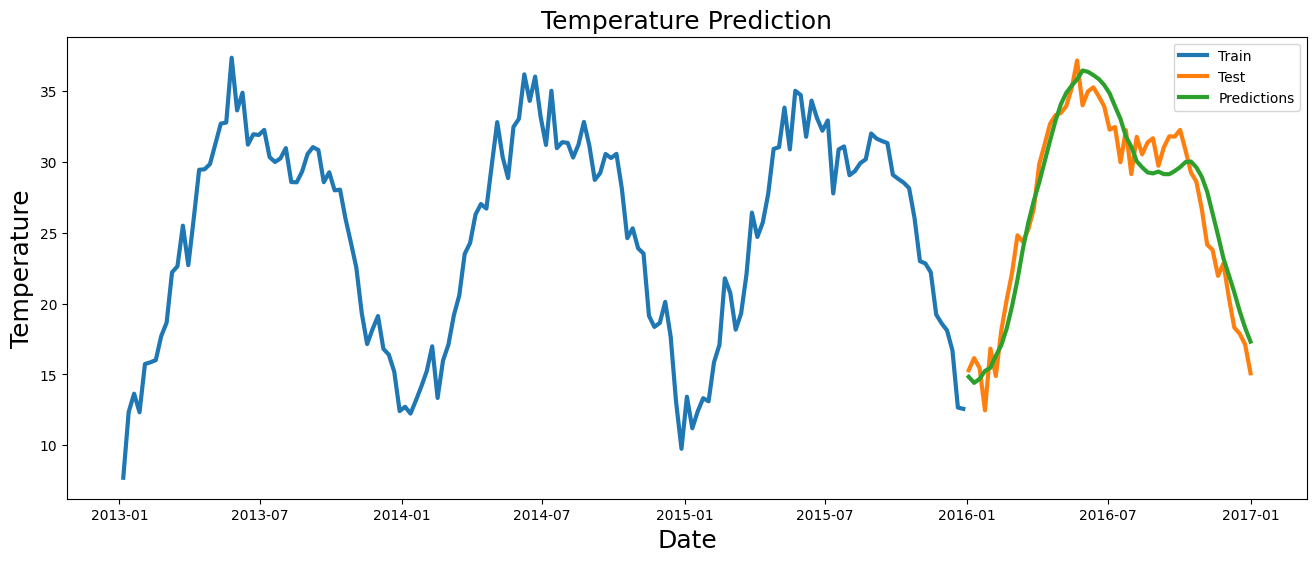

In [126]:
train_weekly = dataset.iloc[:train_size , 0:1]
test_weekly = dataset.iloc[train_size: , 0:1]
test_weekly['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train_weekly['meantemp'], linewidth= 3)
plt.plot(test_weekly['meantemp'], linewidth= 3)
plt.plot(test_weekly["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

### Appliquons Prophet Model

In [127]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


19:00:59 - cmdstanpy - INFO - Chain [1] start processing
19:01:00 - cmdstanpy - INFO - Chain [1] done processing


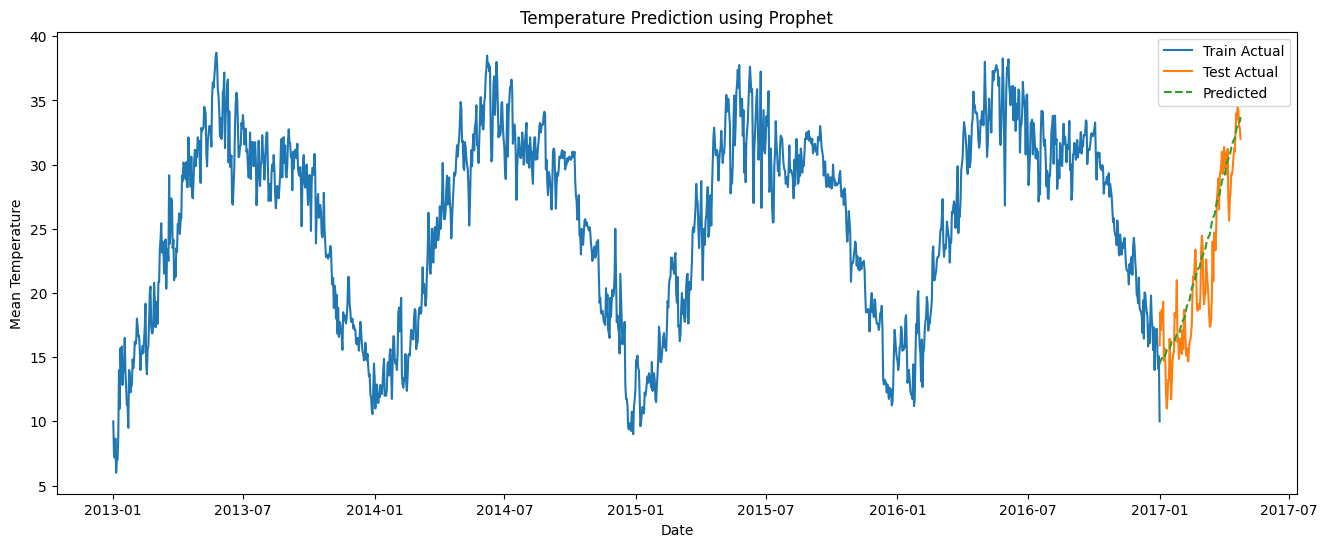

In [128]:
from prophet import Prophet

# Réinitialiser l'index et renommer les colonnes pour l'entraînement
df_train = pd.read_csv("DailyDelhiClimateTrain.csv")
df_test = pd.read_csv("DailyDelhiClimateTest.csv")

df_train.reset_index(inplace=True)
df_train = df_train.rename(columns={'date': 'ds', 'meantemp': 'y'})

# Ajuster le modèle Prophet avec les données d'entraînement
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_train)

# Réinitialiser l'index pour les données de test pour la préparation de la prédiction
df_test.reset_index(inplace=True)
df_test = df_test.rename(columns={'date': 'ds'})

# Préparer le DataFrame pour les futures dates à prédire
future_dates = df_test[['ds']]

# Faire des prédictions
forecast = model.predict(future_dates)

# Visualiser les prédictions avec les données d'entraînement et de test
plt.figure(figsize=(16, 6))
plt.plot(pd.to_datetime(df_train['ds']), df_train['y'], label='Train Actual')
plt.plot(pd.to_datetime(df_test['ds']), df_test['meantemp'], label='Test Actual')
plt.plot(pd.to_datetime(forecast['ds']), forecast['yhat'], label='Predicted', linestyle='dashed')

plt.title('Temperature Prediction using Prophet')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

In [129]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Extraire les valeurs prédites et réelles
y_true = df_test['meantemp'].values
y_pred = forecast['yhat'].iloc[:len(df_test)].values

# Calculer le RMSE
rmse = sqrt(mean_squared_error(y_true, y_pred))
print('RMSE:', rmse)


RMSE: 2.736232931833606
